#### Instalando e Importando Extenções

In [2]:
#!pip install azure-identity
#!pip install azure-storage-blob
#!pip install azure-keyvault-secrets
#!pip install pandas
#pip install matplotlib
#!pip install sqlalchemy
#!pip install pyodbc

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
from azure.keyvault.secrets import SecretClient
from sqlalchemy import create_engine
from io import BytesIO

import pandas as pd
import urllib.parse
import sqlalchemy
import matplotlib.pyplot as plt

#### Selecionando o Arquivo do Container

In [3]:
KEY_VAULT_URL = "https://kv-academy-01.vault.azure.net/"
credential = DefaultAzureCredential()
client = SecretClient(vault_url=KEY_VAULT_URL, credential=credential)
credential = DefaultAzureCredential()
 
# Criar o cliente do Blob Service
blob_service_client = BlobServiceClient(account_url="https://matheus.faneco.blob.core.windows.net", credential=credential)

# Nome do segredo que queremos pegar
secret_blob_name = 'stg-academy-nome'

# Pegando o segredo correspodente
retrieved_blob_secret = client.get_secret(secret_blob_name)

# Função da documentação
def get_blob_service_client_token_credential():
    #montando a url usando o segredo, note o .value para pegar o valor e nao o objeto
    account_url = "https://" + retrieved_blob_secret.value + ".blob.core.windows.net"
    #validando a credencial
    credential = DefaultAzureCredential()
    #Criando o objeto BlobServiceClient
    blob_service_client = BlobServiceClient(account_url, credential=credential)
    #retornando o objeto
    return blob_service_client

# Instanciando um objeto usando a função
blob_service_client = get_blob_service_client_token_credential()

# Uma ação qualquer para mostrar que a conexão foi feita
for container in blob_service_client.list_containers():
    print(container.name)

academy-teste
azure-webjobs-hosts
azure-webjobs-secrets
hands-on
projeto-daniel-danillo-matheus
projeto-gustavo-jonnathan
projeto-luca-aislan
projeto-matheus-thiago
projeto-michelle-thiago
yelpinc


In [4]:
# Utilizando uma função para buscar as credencias, através das keyvault, e retorna-las para acessar os bancos 
def retornaCredenciais(secret_name):
    KEY_VAULT_URL = "https://kv-academy-01.vault.azure.net/"
    credential = DefaultAzureCredential()
    client = SecretClient(vault_url=KEY_VAULT_URL, credential=credential)
 
    retrieved_secret = client.get_secret(secret_name)
    return retrieved_secret.value
 
server = retornaCredenciais("db-academy-server")
database = retornaCredenciais("db-academy-database")
username = retornaCredenciais("db-academy-user")
password = retornaCredenciais("db-academy-password")
driver= '{ODBC Driver 17 for SQL Server}'

server = server
database = database
username = username
password = password
username = urllib.parse.quote_plus(username)

# String de conexão com o SQL Server usando SQLAlchemy e pyodbc
connection_string = rf'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server'
# Criando a engine de conexão
engine = sqlalchemy.create_engine(connection_string)

In [5]:
try:
    connection = engine.connect()
    print("Conexão bem-sucedida!")
    connection.close()
except Exception as e:
    print(f"Erro ao conectar: {e}")


Conexão bem-sucedida!


#### Transformação

In [6]:
# Acessando os containers e lendo o Arquivo CSV , sem baixar na máquina
container_name = 'projeto-daniel-danillo-matheus'
nome_csv = 'transactions_train.csv'

# Obter o cliente do blob e baixar os dados
blob_client = blob_service_client.get_blob_client(container=container_name, blob=nome_csv)
blob_data = blob_client.download_blob().readall()

# Ler o arquivo CSV diretamente em um DataFrame
df = pd.read_csv(BytesIO(blob_data))


In [7]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [8]:
# Dicionário para renomear as colunas
colunas_renomeadas = {
    'step': 'Tempo',
    'type': 'Tipo',
    'amount': 'Valor',
    'nameOrig': 'ContaOrigem',
    'oldbalanceOrig': 'SaldoAntigoOrigem',
    'newbalanceOrig': 'SaldoNovoOrigem',
    'nameDest': 'ContaDestino',
    'oldbalanceDest': 'SaldoAntigoDestino',
    'newbalanceDest': 'SaldoNovoDestino',
    'isFraud': 'Fraude'
}

# Aplicar a renomeação no DataFrame
df = df.rename(columns=colunas_renomeadas)

df.head()

,Tempo,Tipo,Valor,ContaOrigem,SaldoAntigoOrigem,SaldoNovoOrigem,ContaDestino,SaldoAntigoDestino,SaldoNovoDestino,Fraude
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


In [9]:
# Dicionário de tradução de valores
traducao_tipo = {
    'PAYMENT': 'Pagamento',
    'TRANSFER': 'Transferência',
    'CASH_OUT': 'Saque',
    'CASH_IN': 'Depósito',
    'DEBIT': 'Débito',
    'MONEY_TRANSFER': 'Transferência de Dinheiro'
}

# Substituir os valores na coluna 'Tipo' conforme o dicionário
df['Tipo'] = df['Tipo'].replace(traducao_tipo)

df.head()

,Tempo,Tipo,Valor,ContaOrigem,SaldoAntigoOrigem,SaldoNovoOrigem,ContaDestino,SaldoAntigoDestino,SaldoNovoDestino,Fraude
0,1,Pagamento,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,Pagamento,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,Transferência,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,Saque,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,Pagamento,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


#### Análise de valores

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351193 entries, 0 to 6351192
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Tempo               int64  
 1   Tipo                object 
 2   Valor               float64
 3   ContaOrigem         object 
 4   SaldoAntigoOrigem   float64
 5   SaldoNovoOrigem     float64
 6   ContaDestino        object 
 7   SaldoAntigoDestino  float64
 8   SaldoNovoDestino    float64
 9   Fraude              int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 484.6+ MB


In [12]:
# Verificando a quantidade de valores nulos por coluna
nulos_por_coluna = df.isnull().sum()

print("Quantidade de valores nulos por coluna:")
print(nulos_por_coluna)

# Para verificar se há ao menos um valor nulo no DataFrame
tem_nulos = df.isnull().values.any()
print(f"\nO DataFrame contém valores nulos? {'Sim' if tem_nulos else 'Não'}")


Quantidade de valores nulos por coluna:
Tempo                 0
Tipo                  0
Valor                 0
ContaOrigem           0
SaldoAntigoOrigem     0
SaldoNovoOrigem       0
ContaDestino          0
SaldoAntigoDestino    0
SaldoNovoDestino      0
Fraude                0
dtype: int64

O DataFrame contém valores nulos? Não


In [13]:
duplicados = df.duplicated().sum()
print(f'\nDuplicados: {duplicados}')


Duplicados: 0


#### Carregar para o Banco

In [26]:
# Inserindo os dados no SQL Server
df.to_sql('projeto_daniel_danillo_matheus', con=engine, if_exists='replace', index=False)

101

In [58]:
# Nome da tabela
table_name = "projeto_daniel_danillo_matheus"
schema = "dbo"  # Esquema da tabela, geralmente é "dbo"

# Carregar os dados da tabela em um DataFrame
try:
    df = pd.read_sql_table(table_name, engine, schema=schema)
    print("Dados carregados com sucesso!")
    print(df.head())  # Exibir os primeiros registros
except Exception as e:
    print(f"Erro ao carregar a tabela: {e}")

Dados carregados com sucesso!
   Tempo           Tipo      Valor  ContaOrigem  SaldoAntigoOrigem  \
0    132       Depósito  145271.20    C90251397             5076.0   
1    132       Depósito  138307.57   C915282571            36275.0   
2    132  Transferência  532346.66  C1107081042            33581.0   
3    132      Pagamento   27899.98  C1417413941            73165.0   
4    132      Pagamento   20044.23   C503931372            14619.0   

   SaldoNovoOrigem ContaDestino  SaldoAntigoDestino  SaldoNovoDestino  Fraude  
0        150347.20   C841759677          4981698.05        4836426.85       0  
1        174582.57  C1971344738         11030371.00       10892063.43       0  
2             0.00    C71068218          1914986.08        2447332.74       0  
3         45265.02  M1486189111                0.00              0.00       0  
4             0.00   M988484440                0.00              0.00       0  


#### 1: Distribuição de fraudes por tipo de transação

###### O que analisar: Verificar quais tipos de transação têm maior percentual de fraudes (isFraud = 1) em relação ao total de transações.
###### Por que é relevante? Fraudes geralmente estão concentradas em tipos de operações específicas (como Transferencia ou Saque), o que ajuda a priorizar sistemas de monitoramento.
###### Insight: A maior concentração de fraudes ocorre nas transações do tipo Transferenciaencia e Saque, que juntas representam mais de 90% dos casos de fraude. Esses tipos de transação apresentam taxas de fraude muito superiores às demais.
###### Ação sugerida: Implementar monitoramento mais rigoroso para TRANSFER e Saque, incluindo análise de padrões e autenticação em dois fatores.

In [10]:
#Calculo de porcentagem de fraudes por tipo de transação!
fraude_por_tipo = (df.groupby("Tipo")["Fraude"].mean().sort_values(ascending=False) * 100)
display(fraude_por_tipo)

Tipo
Transferência    0.723745
Saque            0.173191
Depósito         0.000000
Débito           0.000000
Pagamento        0.000000
Name: Fraude, dtype: float64

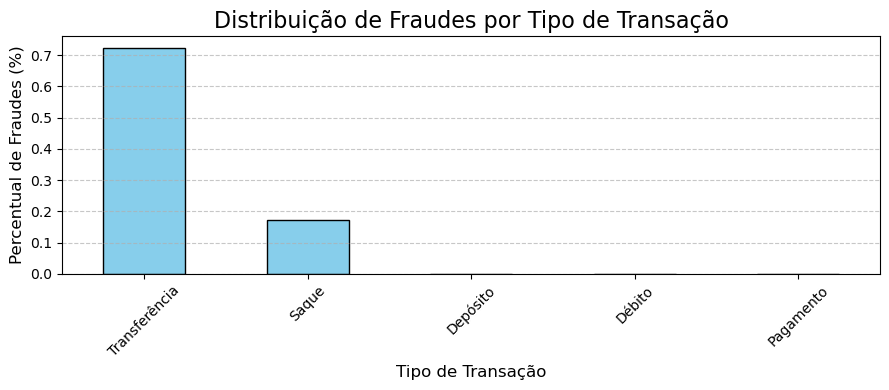

In [11]:
# Dados da análise
fraude_por_tipo = (df.groupby("Tipo")["Fraude"].mean().sort_values(ascending=False) * 100)

# Criando o gráfico de barras
plt.figure(figsize=(9, 4))
fraude_por_tipo.plot(kind='bar', color='skyblue', edgecolor='black')

# Configurando o gráfico
plt.title("Distribuição de Fraudes por Tipo de Transação", fontsize=16)
plt.ylabel("Percentual de Fraudes (%)", fontsize=12)
plt.xlabel("Tipo de Transação", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()
plt.show()


======================================================================================================

#### 2: Fraudes por valor da transação

###### O que analisar: Categorizar as transações em faixas de valores (ex.: baixo (<5.000), médio (5.000-50.000), alto (>50.000)) e identificar em quais faixas as fraudes são mais frequentes.
###### Por que é relevante? Detectar se valores extremos (muito altos ou baixos) estão associados a fraudes.
###### Insight: A maioria das fraudes está concentrada em transações de valor médio (R$5.000 a R$50.000). No entanto, transações de valores extremamente altos (>R$50.000) apresentam uma proporção significativamente maior de fraudes em relação ao total.
###### Ação sugerida: Configurar alertas automáticos para transações na faixa de valor médio e validar manualmente transações de valores muito altos.

In [12]:
# Calcular os quartis para a coluna "Valor"
q1 = df["Valor"].quantile(0.25)  # Primeiro Quartil (25%)
q2 = df["Valor"].quantile(0.50)  # Segundo Quartil (Mediana - 50%)
q3 = df["Valor"].quantile(0.75)  # Terceiro Quartil (75%)

# Criar bins dinamicamente com base nos quartis
bins = [0, q1, q3, float("inf")]
labels = ["Baixo (<Q1)", "Médio (Q1-Q3)", "Alto (>Q3)"]

# Criar uma nova coluna para categorização com base nos quartis
df["FaixaValor"] = pd.cut(df["Valor"], bins=bins, labels=labels, right=False)

# Calcular o total de fraudes por faixa de valor
fraude_por_faixa = df.groupby("FaixaValor", observed=True)["Fraude"].sum().sort_values(ascending=False)
display(fraude_por_faixa)

FaixaValor
Alto (>Q3)       5070
Médio (Q1-Q3)    2333
Baixo (<Q1)       314
Name: Fraude, dtype: int64

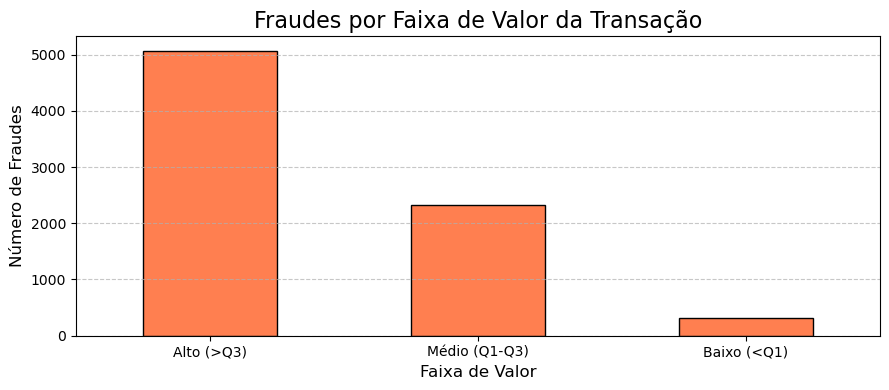

In [13]:
# Dados da análise
fraude_por_faixa = df.groupby("FaixaValor", observed=True)["Fraude"].sum().sort_values(ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(9, 4))
fraude_por_faixa.plot(kind='bar', color='coral', edgecolor='black')

# Configurando o gráfico
plt.title("Fraudes por Faixa de Valor da Transação", fontsize=16)
plt.ylabel("Número de Fraudes", fontsize=12)
plt.xlabel("Faixa de Valor", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

======================================================================================================

#### 3: Análise de Discrepâncias nas transações: Fraudes.

###### O que analisar: Identificar padrões nos saldos anteriores (OldbalanceOrg) e posteriores (NewbalanceOrig) das transações fraudulentas.
###### Exemplos de padrões:
###### Saldos que "zeram" após a transação.
###### Diferenças entre saldo esperado e real.
###### Por que é relevante? Fraudes podem gerar inconsistências nos saldos (ex.: fraudes que "limpam" o saldo da conta).
###### Insight: Transações fraudulentas frequentemente "zeram" o saldo da conta de origem, indicando um comportamento recorrente de esvaziar contas.
###### Ação sugerida: Implementar monitoramento para sinalizar quando uma transação deixa o saldo da conta próximo de zero.

In [14]:
#Filtrar apenas transações onde temos fraudes
df_fraude = df[df["Fraude"] == 1].copy()

#Calcular o saldo esperado (saldo anterior menos o valor da transação)
df_fraude["SaldoEsperado"] = df_fraude["SaldoAntigoOrigem"] - df_fraude["Valor"]

#Calcular a discrepância entre o saldo esperado e o saldo real
df_fraude["Discrepancia"] = df_fraude["SaldoEsperado"] - df_fraude["SaldoNovoOrigem"]

In [15]:
# Exibir as primeiras linhas do DataFrame com as novas colunas
display(df_fraude.head())

# Exibir apenas as colunas de interesse
display(df_fraude[["SaldoAntigoOrigem", "SaldoNovoOrigem", "SaldoEsperado", "Discrepancia"]].head())


,Tempo,Tipo,Valor,ContaOrigem,SaldoAntigoOrigem,SaldoNovoOrigem,ContaDestino,SaldoAntigoDestino,SaldoNovoDestino,Fraude,FaixaValor,SaldoEsperado,Discrepancia
2,1,Transferência,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,Baixo (<Q1),0.0,0.0
3,1,Saque,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,Baixo (<Q1),0.0,0.0
251,1,Transferência,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,Baixo (<Q1),0.0,0.0
252,1,Saque,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,Baixo (<Q1),0.0,0.0
680,1,Transferência,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,Médio (Q1-Q3),0.0,0.0


,SaldoAntigoOrigem,SaldoNovoOrigem,SaldoEsperado,Discrepancia
2,181.0,0.0,0.0,0.0
3,181.0,0.0,0.0,0.0
251,2806.0,0.0,0.0,0.0
252,2806.0,0.0,0.0,0.0
680,20128.0,0.0,0.0,0.0


In [16]:
import numpy as np

#Definir uma tolerância - margem de error
tolerancia = 1e-6

#Filtrar discrepâncias que estão fora da margem de erro
df_discrepancias = df_fraude[np.abs(df_fraude["Discrepancia"]) > tolerancia].reset_index()

#Exibir resultados relevantes
display(df_discrepancias[["SaldoAntigoOrigem", "Valor", "SaldoNovoOrigem", "SaldoEsperado", "Discrepancia", "Tipo"]])


,SaldoAntigoOrigem,Valor,SaldoNovoOrigem,SaldoEsperado,Discrepancia,Tipo
0,0.00,416001.33,0.00,-416001.33,-416001.33,Saque
1,4499.08,132842.64,0.00,-128343.56,-128343.56,Saque
2,0.00,181728.11,0.00,-181728.11,-181728.11,Saque
3,0.00,1078013.76,0.00,-1078013.76,-1078013.76,Transferência
4,0.00,277970.88,0.00,-277970.88,-277970.88,Saque
5,0.00,1933920.80,0.00,-1933920.80,-1933920.80,Transferência
6,0.00,149668.66,0.00,-149668.66,-149668.66,Saque
7,0.00,222048.71,0.00,-222048.71,-222048.71,Saque
8,0.00,454859.39,0.00,-454859.39,-454859.39,Saque
9,79466.45,123194.95,0.00,-43728.50,-43728.50,Transferência


In [17]:
# Ordenar as discrepâncias em ordem decrescente de valor absoluto
top_discrepancias = df_discrepancias.reindex(df_discrepancias["Discrepancia"].abs().sort_values(ascending=False).index)

# Selecionar as 10 maiores discrepâncias
top_discrepancias = top_discrepancias.head(10)

# Exibir os resultados
display(top_discrepancias[["SaldoAntigoOrigem", "Valor", "SaldoNovoOrigem", "Discrepancia", "Tipo"]])

,SaldoAntigoOrigem,Valor,SaldoNovoOrigem,Discrepancia,Tipo
38,10399045.08,10000000.00,10399045.08,-10000000.00,Transferência
33,19585040.37,10000000.00,19585040.37,-10000000.00,Transferência
34,19585040.37,9585040.37,19585040.37,-9585040.37,Transferência
27,4953893.08,4953893.08,4953893.08,-4953893.08,Transferência
32,4892193.09,4892193.09,4892193.09,-4892193.09,Transferência
35,3576297.10,3576297.10,3576297.10,-3576297.10,Transferência
40,3441041.46,3441041.46,3441041.46,-3441041.46,Transferência
37,2542664.27,2542664.27,2542664.27,-2542664.27,Transferência
5,0.00,1933920.80,0.00,-1933920.80,Transferência
22,0.00,1395850.55,0.00,-1395850.55,Transferência


##### 3.1: Impacto total de valor em transações.

In [18]:
impacto_total = df_discrepancias["Discrepancia"].abs().sum()
print(f"Impacto total de valores: R$ {impacto_total:.2f}")

Impacto total de valores: R$ 61654178.87


======================================================================================================

#### 4: Contas mais associadas a fraudes

###### O que analisar: Quais contas de origem (nameOrig) aparecem com maior frequência em transações fraudulentas.
###### Por que é relevante? Contas que realizam muitas fraudes podem ser bots ou usadas para operações maliciosas.
###### Insight: Algumas contas aparecem repetidamente em transações fraudulentas, indicando possível uso automatizado ou comportamento coordenado.
###### Ação sugerida: Investigar e, se necessário, bloquear contas com alta frequência de transações fraudulentas.

In [19]:
# Filtrar as transações fraudulentas (ajuste conforme necessário)
df_fraudulentas = df_fraude[df_fraude['Fraude'] == 1]  # Ajuste conforme sua coluna de identificação de fraude

# Contar quantas vezes cada conta 'ContaOrigem' aparece nas transações fraudulentas
contagem_contas_fraudulentas = df_fraudulentas['ContaOrigem'].value_counts()

# Filtrar as contas que têm mais de uma fraude
contas_mais_de_1_fraude = contagem_contas_fraudulentas[contagem_contas_fraudulentas == 1]

# Exibir as contas com mais de uma fraude
display(contas_mais_de_1_fraude)


ContaOrigem
C1305486145    1
C1158527799    1
C915102234     1
C9486206       1
C777622163     1
              ..
C369516790     1
C1926697362    1
C1370685766    1
C174356762     1
C1491503658    1
Name: count, Length: 7717, dtype: int64

In [20]:
print(f"Número de transações fraudulentas: {len(df_fraudulentas)}")

Número de transações fraudulentas: 7717


======================================================================================================

#### 5: Tipo de operação realizada para as transações fraudulentas

###### O que analisar: Identificar se certas inconsistências no saldo ocorrem em tipos específicos de transações fraudulentas.
###### Exemplo: OldbalanceOrg e NewbalanceOrig têm valores irreais, como saldos negativos ou muito altos.
###### Por que é relevante? Ajuda a entender se certas operações fraudulentas exploram erros no saldo.
###### Insight: Transações fraudulentas do tipo TRANSFER frequentemente apresentam inconsistências nos saldos, como valores negativos ou irreais.
###### Ação sugerida: Desenvolver regras de monitoramento em tempo real para identificar e bloquear transações com saldos inconsistentes.

In [21]:
#Verificar e tratar valores nulos nas colunas de saldo
df_fraudulentas = df_fraudulentas.dropna(subset=['SaldoAntigoOrigem', 'SaldoNovoOrigem'])
limite_alto = 1e6
limite_baixo = 3

#Agora, define a inconsistência de saldo
df_fraudulentas['InconsistenciaSaldoOrigem'] = (
    (df_fraudulentas['SaldoAntigoOrigem'] < 0) | 
    (df_fraudulentas['SaldoNovoOrigem'] < 0) | 
    (df_fraudulentas['SaldoAntigoOrigem'] > limite_alto) | 
    (df_fraudulentas['SaldoNovoOrigem'] > limite_alto) |
    (df_fraudulentas['SaldoAntigoOrigem'] < limite_baixo) |  
    (df_fraudulentas['SaldoNovoOrigem'] < limite_baixo)
)

#Verificar novamente a contagem por tipo
contagem_inconsistencias_tipo = df_fraudulentas.groupby('Tipo')['InconsistenciaSaldoOrigem'].sum()
display(contagem_inconsistencias_tipo)


Tipo
Saque            3867
Transferência    3847
Name: InconsistenciaSaldoOrigem, dtype: int64

In [22]:
#Verificar a quantidade de valores NaN nas colunas de saldo
print(df_fraudulentas[['SaldoAntigoOrigem', 'SaldoNovoOrigem']].isna().sum())

SaldoAntigoOrigem    0
SaldoNovoOrigem      0
dtype: int64


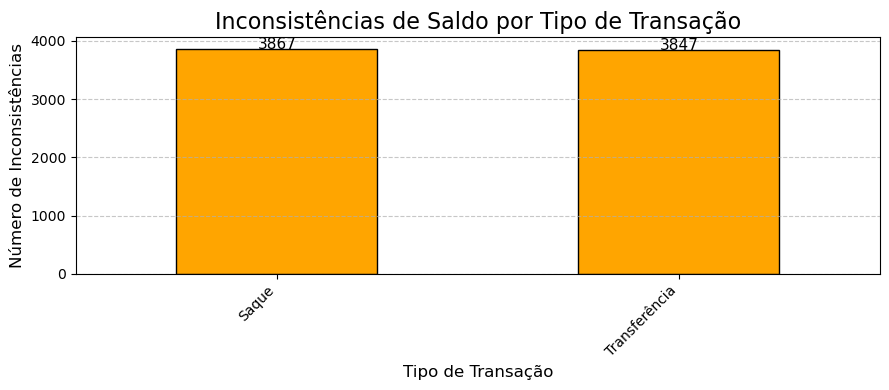

In [23]:
import matplotlib.pyplot as plt

# Calcular a contagem de inconsistências por tipo
contagem_inconsistencias_tipo = df_fraudulentas.groupby('Tipo')['InconsistenciaSaldoOrigem'].sum()

# Verificar se existem inconsistências
if not contagem_inconsistencias_tipo.empty:
    # Criar o gráfico de barras
    plt.figure(figsize=(9, 4))
    ax = contagem_inconsistencias_tipo.sort_values(ascending=False).plot(kind='bar', color='orange', edgecolor='black')

    # Adicionar os valores sobre as barras
    for i, v in enumerate(contagem_inconsistencias_tipo.sort_values(ascending=False)):
        plt.text(i, v + 0.5, f'{v:.0f}', ha='center', fontsize=11, color='black')

    # Configurações do gráfico
    plt.title("Inconsistências de Saldo por Tipo de Transação", fontsize=16)
    plt.xlabel("Tipo de Transação", fontsize=12)
    plt.ylabel("Número de Inconsistências", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Exibir o gráfico
    plt.tight_layout()
    plt.show()
else:
    print("Não foram encontradas inconsistências de saldo nas transações fraudulentas.")


======================================================================================================

#### 6: Fraudes por destinatário

###### O que analisar: Identificar quais destinatários (nameDest) aparecem mais frequentemente em transações fraudulentas.
###### Por que é relevante? Certos destinatários podem estar envolvidos repetidamente em fraudes, indicando um padrão ou uma rede de contas.
###### Insight: Alguns destinatários aparecem de forma recorrente em transações fraudulentas, sugerindo que podem ser pontos finais para operações maliciosas.
###### Ação sugerida: Bloquear ou monitorar transações para esses destinatários.

In [24]:
df_fraudulentas = df[df['Fraude'] == 1]

# Contar a quantidade de transações fraudulentas para cada destinatário (ContaDestino)
contagem_destinatarios_fraudulentos = df_fraudulentas['ContaDestino'].value_counts()

# Selecionar os 10 destinatários mais frequentes em transações fraudulentas
top_destinatarios_fraudulentos = contagem_destinatarios_fraudulentos.head(10)

# Exibir os resultados
display(top_destinatarios_fraudulentos)

ContaDestino
C385133759     2
C1013511446    2
C475338087     2
C2020337583    2
C1827219533    2
C1981613973    2
C644163395     2
C1185292292    2
C967226405     2
C105660024     2
Name: count, dtype: int64

======================================================================================================

#### 7: Fraudes identificadas por valor na mesma faixa de tempo (tempo como tempo sequencial)

###### O que analisar: Usar a coluna step para investigar padrões temporais em fraudes, como sequências rápidas de transações de valores altos ou baixos.
###### Por que é relevante? Sequências rápidas de transações de alto valor podem ser sinal de fraude.
###### Insight: Transações fraudulentas frequentemente ocorrem em curtos períodos de tempo (step) e incluem valores muito altos (>R$50.000).
###### Ação sugerida: Configurar o sistema para identificar e alertar sobre transações sequenciais de alto valor associadas à mesma conta.

In [36]:
# Filtrar transações fraudulentas
df_fraudulentas = df[df['Fraude'] == 1].copy()

#Verifica se há discrepâncias de valores em transações fraudulentas
#Considerando valores muito altos ou baixos como discrepantes
limite_superior = 1e6  # Limite superior arbitrário para valores discrepantes
limite_inferior = 1e3  # Limite inferior arbitrário para valores relevantes

# Verificar discrepâncias também nos saldos
df_fraudulentas['Discrepancia'] = (
    (df_fraudulentas['Valor'] > limite_superior) | 
    (df_fraudulentas['Valor'] < limite_inferior) |
    (df_fraudulentas['SaldoAntigoOrigem'] != df_fraudulentas['SaldoNovoOrigem']) |
    (df_fraudulentas['SaldoAntigoDestino'] != df_fraudulentas['SaldoNovoDestino'])
)

# Separar transações discrepantes
df_discrepantes = df_fraudulentas[df_fraudulentas['Discrepancia'] == True]

# Selecionar apenas as colunas de interesse
colunas_interesse = ['Tempo', 'Tipo', 'Valor', 'ContaOrigem', 'SaldoAntigoOrigem', 'SaldoNovoOrigem', 
                     'ContaDestino', 'SaldoAntigoDestino', 'SaldoNovoDestino', 'Fraude', 'Discrepancia']

df_discrepantes = df_discrepantes[colunas_interesse]

# Exibir transações discrepantes
display(df_discrepantes.head(10))

,Tempo,Tipo,Valor,ContaOrigem,SaldoAntigoOrigem,SaldoNovoOrigem,ContaDestino,SaldoAntigoDestino,SaldoNovoDestino,Fraude,Discrepancia
2,1,Transferência,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,True
3,1,Saque,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,True
251,1,Transferência,2806.00,C1420196421,2806.00,0.0,C972765878,0.0,0.00,1,True
252,1,Saque,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.0,0.00,1,True
680,1,Transferência,20128.00,C137533655,20128.00,0.0,C1848415041,0.0,0.00,1,True
681,1,Saque,20128.00,C1118430673,20128.00,0.0,C339924917,6268.0,12145.85,1,True
724,1,Saque,416001.33,C749981943,0.00,0.0,C667346055,102.0,9291619.62,1,True
969,1,Transferência,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.0,0.00,1,True
970,1,Saque,1277212.77,C467632528,1277212.77,0.0,C716083600,0.0,2444985.19,1,True
1115,1,Transferência,35063.63,C1364127192,35063.63,0.0,C1136419747,0.0,0.00,1,True
